## Background

information spreads rapidly through various online platforms. However, not all disseminated **information is factual**, and the **spread of fake news** poses a significant challenge, negatively impacting individuals and society. To address this issue, technologies like **deep learning**, particularly **Long Short-Term Memory (LSTM)**, can be utilized to analyze and classify news based on its authenticity. LSTM is chosen for its superior ability to process text data and identify patterns in sequential data.
This **project aims** to **develop an LSTM-based machine learning model** capable of automatically **detecting and classifying fake news**. The project seeks to **assist individuals and digital platforms** in filtering out false information and enhancing trust in credible news sources.

## Import Library & Data

In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/vivi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vivi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df_fake = pd.read_csv('../data/fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_real = pd.read_csv('../data/true.csv')
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
df_fake['label'] = 'Fake'
df_real['label'] = 'Real'
df = pd.concat([df_fake,df_real])
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


## Data Cleaning

In [8]:
print(f'Data rows: {df.shape[0]}, Data columns: {df.shape[1]}')

Data rows: 44898, Data columns: 5


In [9]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [10]:
df.duplicated().sum()

209

In [11]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f'Data rows after cleaning: {df.shape[0]}, Data columns after cleaning: {df.shape[1]}')

Data rows after cleaning: 44689, Data columns after cleaning: 5


## Preprocessing Text

### Case Folding & Cleaning Text

In [12]:
def clean_text(text):
    # Converting all text to lowercase
    text = text.lower()
    
    # Delete link/URL
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    
    # Delete emoji and characters non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Normalize Words
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "i am", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    # Remove punctuation and other symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Delete numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Removing double spaces that may form
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
df['text'] = df['text'].apply(clean_text)

In [13]:
df.sample(5)

,title,text,subject,date,label
13895,Irish government set to fall weeks before Brex...,dublin reuters ireland s minority government l...,worldnews,"November 24, 2017",Real
7303,"This Trump Supporter Is Going To Jail, And He...",while donald trump has staked a large part of ...,News,"March 25, 2016",Fake
1237,GOP Candidate Completely Screws Up And Admits...,it s hardly a well kept secret forty years of ...,News,"June 7, 2017",Fake
8940,Puerto Rico bailout more likely if Congress do...,washington reuters without action by congress ...,politicsNews,"June 28, 2016",Real
19467,FLASHBACK: Remember When Obama Was Caught Tell...,here s obama defending russia during a debate ...,left-news,"Dec 11, 2016",Fake


### Stopwords & Stemming

In [14]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

df['text'] = df['text'].apply(preprocess_text)

In [15]:
df.sample(5)

,title,text,subject,date,label
18318,Search ends for bodies in Mexico City after ea...,mexico citi reuter search victi am earthquak k...,worldnews,"October 4, 2017",Real
3287,"White House, Congress Republicans nearing key ...",washington reuter trump administr top republic...,politicsNews,"June 9, 2017",Real
19091,WILL VILE LEFTISTS Turn Democrats Away?…WATCH ...,group mostli pro life colleg student came toge...,left-news,"Feb 24, 2017",Fake
3901,WATCH: Trump Adviser Stammers While Being Gri...,less hour elect day thing go disastr donald tr...,News,"November 7, 2016",Fake
908,Trump does not recall suggestion of Putin meet...,washington reuter u presid donald trump recal ...,politicsNews,"November 1, 2017",Real


## Exploratory Data Analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   label    44689 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [17]:
words_fake = df[df['label'] == 'Fake']
list_words_fake = words_fake['text']
words_real = df[df['label'] == 'Real']
list_words_real = words_real['text']

### What Happened?

/tmp/ipykernel_100113/3861557257.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='label', palette="Set2", edgecolor="black")


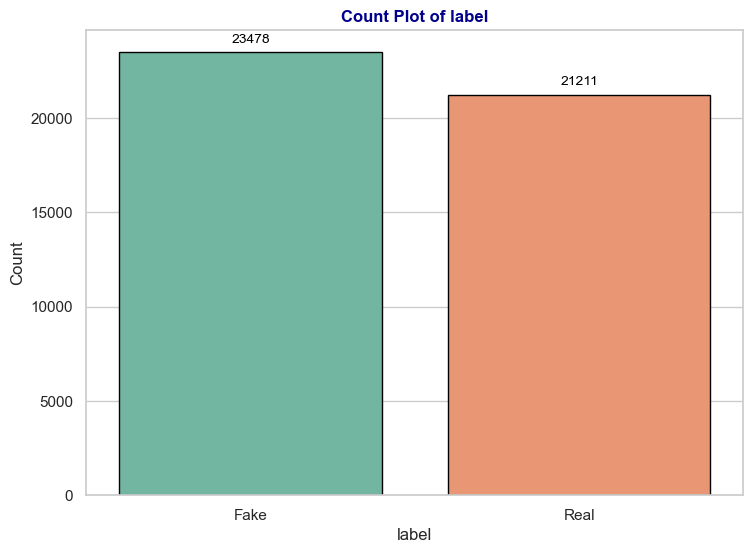

In [18]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=df, x='label', palette="Set2", edgecolor="black")
plt.title(f'Count Plot of label', fontweight='bold', color='darkblue')
plt.ylabel("Count", fontsize=12)
for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), textcoords='offset points', fontsize=10, color='black')
plt.tight_layout(pad=2)
plt.show()

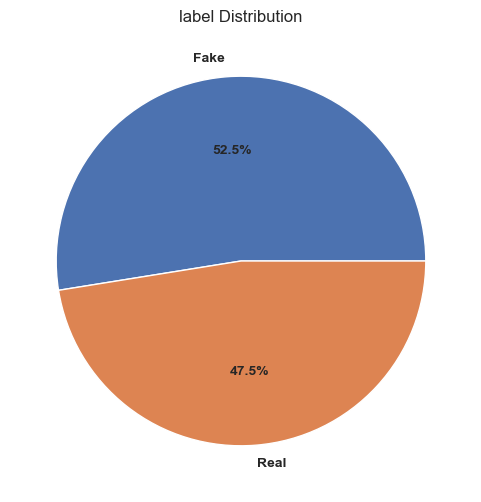

In [19]:
plt.figure(figsize=(6,6))
plt.pie(x =df['label'].value_counts().values , labels=df['label'].value_counts().keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"})
plt.title('label Distribution') 
plt.show()

The dataset contains **23478 instances (52.5%) labeled as "Fake News"** and **21211 instances (47.5%) labeled as "Real News"**.

### What the most type of news is real or fake?

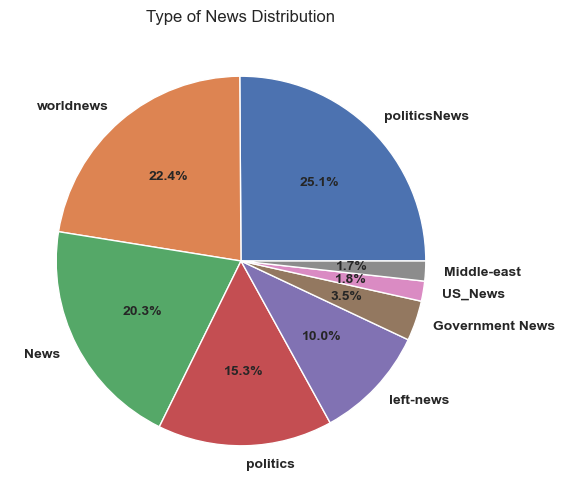

In [20]:
plt.figure(figsize=(6,6))
plt.pie(x =df['subject'].value_counts().values , labels=df['subject'].value_counts().keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"})
plt.title('Type of News Distribution') 
plt.show()

In [21]:
pd.crosstab(df['label'] , df['subject']).T.style.background_gradient(subset=['Fake'],cmap='Reds')\
.background_gradient(subset=['Real'] , cmap='Greens')

label,Fake,Real
subject,,
Government News,1570,0
Middle-east,778,0
News,9050,0
US_News,783,0
left-news,4459,0
politics,6838,0
politicsNews,0,11220
worldnews,0,9991


- The category with the **most fake news** is **News** with **9,050** fake articles, followed by **politics** with **6,838** fake articles.
- The category with the **most real news** is **politicsNews** with **11,220** real articles, followed by **worldnews** with **9,991** real articles.

### What words frequently appear in news?

/tmp/ipykernel_100113/3682882102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


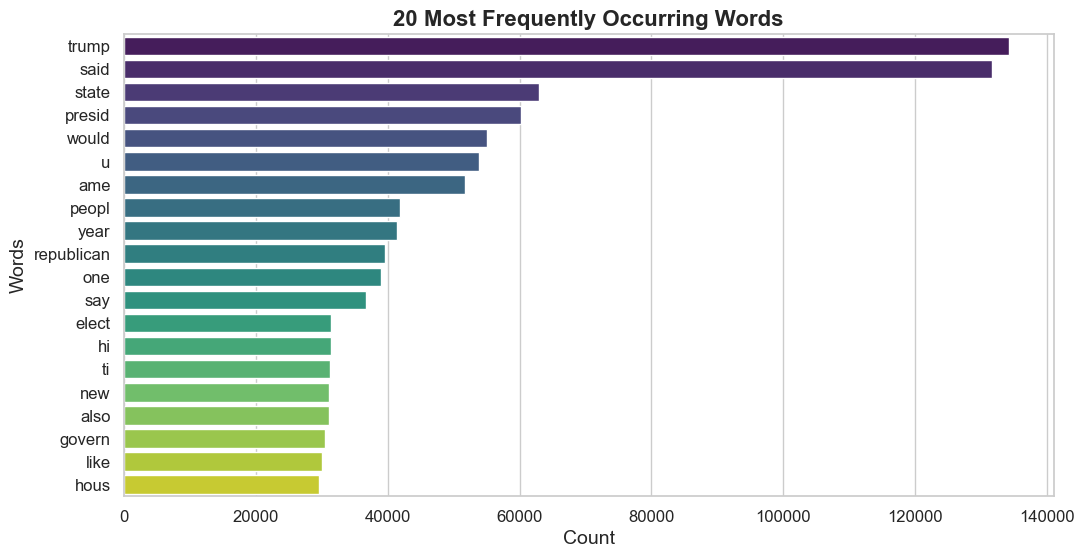

In [22]:
text = " ".join(df["text"])
tokens = text.split()

word_counts = Counter(tokens)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Setup tema seaborn
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("20 Most Frequently Occurring Words", fontsize=16, fontweight='bold')
plt.xlabel("Count", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

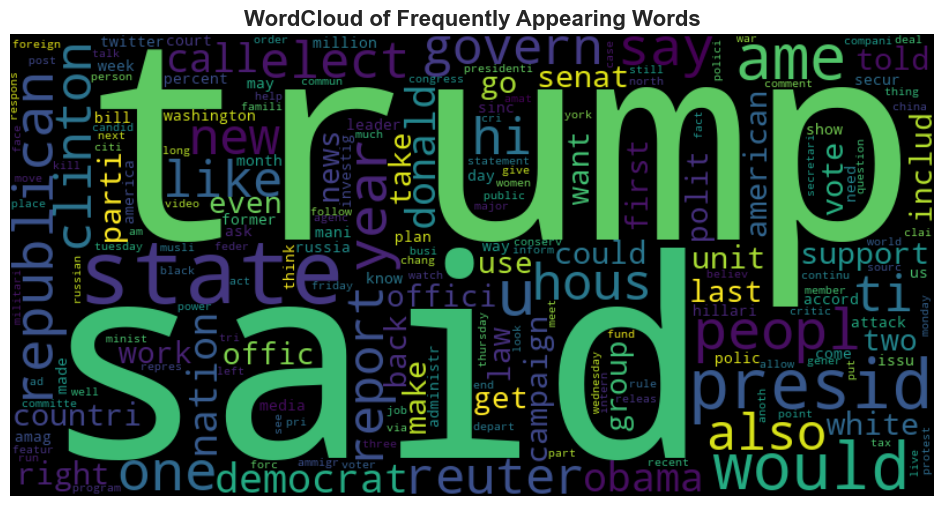

In [23]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='viridis'
).generate_from_frequencies(word_counts)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Frequently Appearing Words", fontsize=16, fontweight='bold')
plt.show()

"trump," "said," "state," "presid" (likely stemming from "president"), and "would."
These words suggest a strong focus on political events and statements, particularly involving the U.S. presidency.

### What words often appear in fake news?

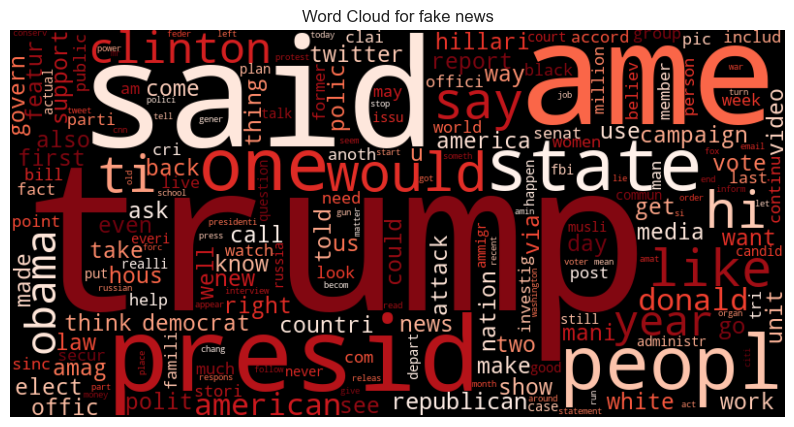

In [24]:
words_fake = ' '.join(list_words_fake)

fake = words_fake.split()
word_counts_fake = Counter(fake)

common_words_fake = word_counts_fake.most_common(10)

wordcloud_fake = WordCloud(
    width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(word_counts_fake)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for fake news")
plt.show()

"trump," "ame" (possibly stemming from "America"), "presid" (likely "president"), "like," "clinton," and "peopl."
These words indicate a significant focus on political figures and events, often involving controversial or polarizing topics, which are common in fake news narratives.

### What words often appear in real news?

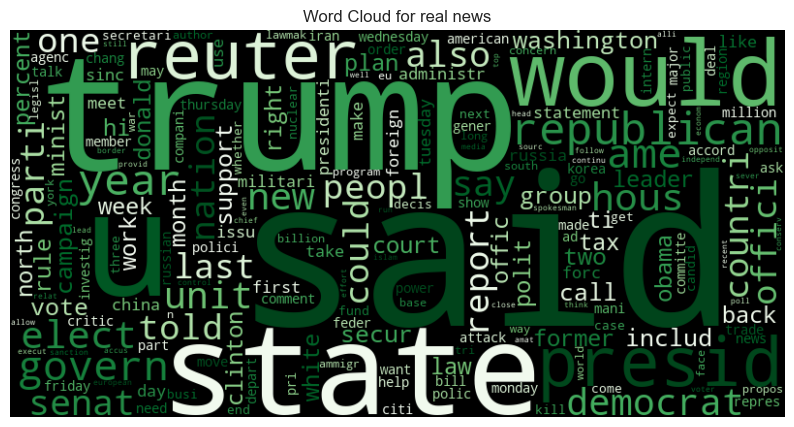

In [25]:
words_real = ' '.join(list_words_real)

real = words_real.split()
word_counts_real = Counter(real)

common_words_real = word_counts_real.most_common(10)


wordcloud_real = WordCloud(
    width=800, height=400, background_color='black', colormap='Greens').generate_from_frequencies(word_counts_real)

# Plotting the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for real news")
plt.show()

"reuter" (likely referring to Reuters, a reputable news agency), "republican," "presid" (likely "president"), "trump," "state," and "said."
These words reflect a focus on official reports, political figures, and statements, which are characteristic of real news articles based on credible sources and factual reporting.

## Feature Extraction

In [26]:
df = df[['text','label']]
df.sample(5)

,text,label
2673,washington reuter top democrat u hous repres i...,Real
9228,tomorrow alabama resid includ thousand felon r...,Fake
10807,let play fun game call hell nanci say everi ti...,Fake
9051,reuter new jersey governor chri christi tuesda...,Real
1148,missouri state repres make nation headlin toda...,Fake


In [27]:
texts = df['text'].values
labels = df['label'].values

In [28]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
for i, atribut in enumerate(label_encoder.classes_):
    print(f'The attribute of "{atribut}" is converted to: {i}')

The attribute of "Fake" is converted to: 0
The attribute of "Real" is converted to: 1


In [29]:
vocab_size = 10000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=vocab_size) 
tokenizer.fit_on_texts(texts) 
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(encoded_labels)

In [30]:
import pickle
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer saved.")

Tokenizer saved.


## Data Splitting

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (35751, 100)
X_test Shape: (8938, 100)
y_train Shape: (35751,)
y_test Shape: (8938,)


## Model Development

In [32]:
from tensorflow.keras.regularizers import l2
model = models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length),
    layers.LSTM(100,kernel_regularizer=l2(0.01)),
    # layers.Dropout(0.5),  
    # layers.LSTM(64, kernel_regularizer=l2(0.01)),
    # layers.Dropout(0.2),  
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/home/vivi/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-21 03:42:17.780079: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [33]:
from tensorflow.keras.utils import plot_model
# Build the model
model.build(input_shape=(None, max_sequence_length))  # Replace max_sequence_length with the actual value
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,086,929 (4.15 MB)

 Trainable params: 1,086,929 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [34]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",       
    patience=3,               
    verbose=1,
    restore_best_weights=True 
)
callbacks = [
    early_stopping_callback
]

In [35]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1,
    # validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 167s 141ms/step - accuracy: 0.9234 - loss: 0.4030 - val_accuracy: 0.9810 - val_loss: 0.0646
Epoch 2/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 114s 102ms/step - accuracy: 0.9870 - loss: 0.0513 - val_accuracy: 0.9781 - val_loss: 0.0687
Epoch 3/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 116s 104ms/step - accuracy: 0.9918 - loss: 0.0363 - val_accuracy: 0.9723 - val_loss: 0.0874
Epoch 4/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 107s 96ms/step - accuracy: 0.9957 - loss: 0.0210 - val_accuracy: 0.9869 - val_loss: 0.0452
Epoch 5/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 123s 110ms/step - accuracy: 0.9962 - loss: 0.0186 - val_accuracy: 0.9868 - val_loss: 0.0484
Epoch 6/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 121s 108ms/step - accuracy: 0.9982 - loss: 0.0117 - val_accuracy: 0.9795 - val_loss: 0.0689
Epoch 7/10
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 112s 100ms/step - accuracy: 0.9985 - loss: 0.0095 - val_accuracy: 0.9894 - val_loss: 0.0515
Epoch 7: early stopping
Restoring model weights from the end of

In [ ]:
model.save('fake_news_model.h5')
with open(f"../models/lstm.pkl", "wb") as f:
        pickle.dump(model, f)

## Evaluation

In [37]:
test_loss, test_accuracy = model.evaluate(X_test,y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9856 - loss: 0.0488
Test Accuracy: 98.69%


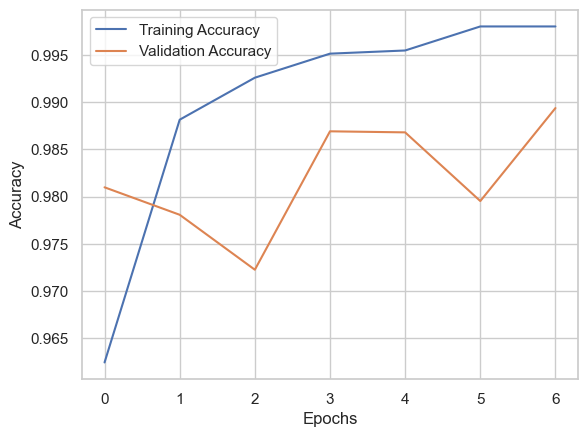

In [38]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


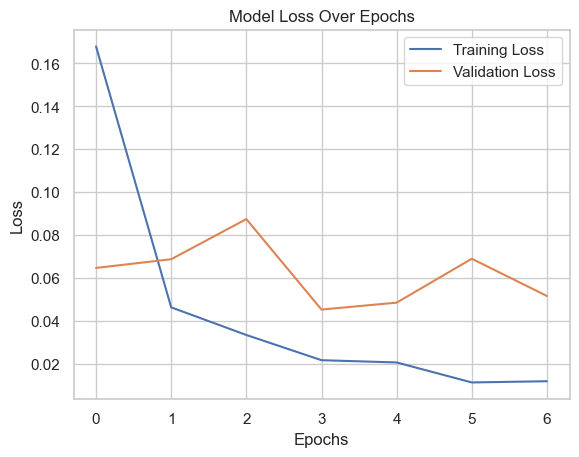

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()


In [48]:
X_train.shape , X_test.shape

((35751, 100), (8938, 100))

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
y_hat = model.predict(X_test)
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4738
           1       0.99      0.98      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



Text(67.25, 0.5, 'Real Labels')

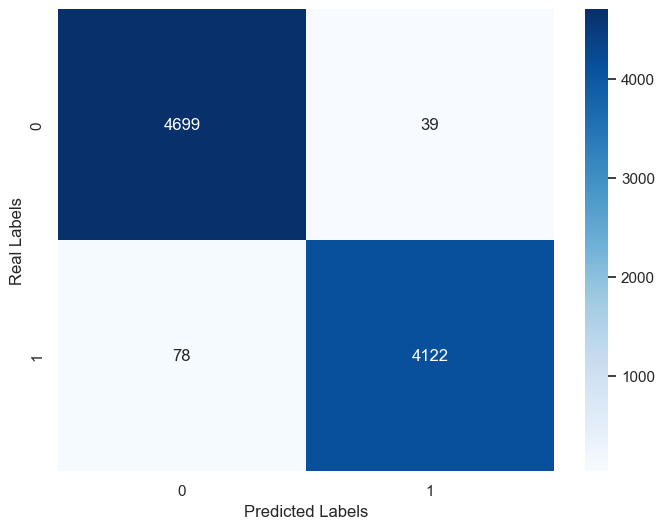

In [41]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

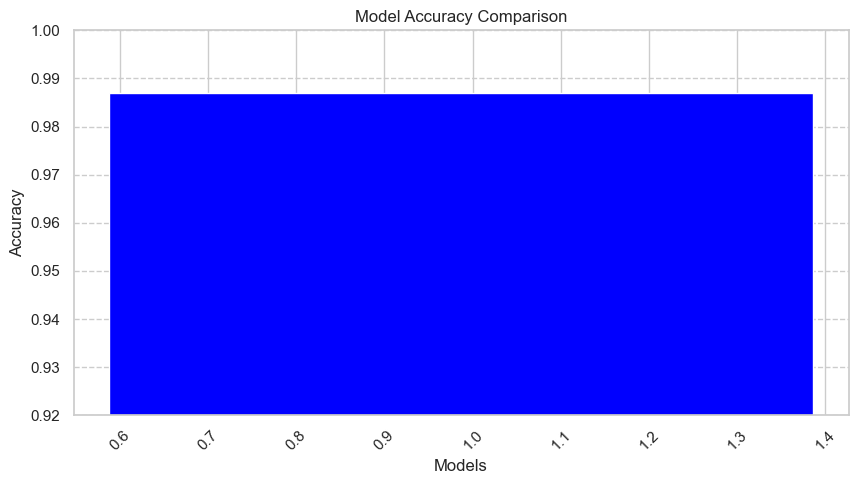

In [51]:
# Plot improved accuracy comparison graph
plt.figure(figsize=(10,5))
plt.bar(test_accuracy, test_accuracy, color=['blue', 'green', 'red', 'purple', 'orange'])

# Adding value labels on top of bars
# yval = bar.get_height()
# plt.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval*100,2)}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylim(0.92, 1)  # Accuracy y-axis ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=1)

plt.show()

In [47]:
# Function to preprocess and predict
def predict_news(news_text):
    # Tokenize input using NLTK
    tokens = Tokenizer(news_text.lower())  # Lowercase & tokenize
    
    # Convert tokens to a sequence using the trained tokenizer
    sequences = tokenizer.texts_to_sequences([tokens])  # Directly pass tokenized words as a list
    
    # Pad the sequence to match the model's input size
    padded_sequence = pad_sequences(sequences, maxlen=100)  # Ensure fixed length
    
    # Predict using trained model
    prediction = model.predict(padded_sequence)[0][0]  # Get prediction score

    # Convert probability output to class label
    return "FAKE News" if prediction < 0.5 else "REAL News"

# Get user input
news_input = input("Enter a news statement: ")  
result = predict_news(news_input)

print("\nPrediction:", result)  # Display FAKE or REAL

TypeError: 'bool' object is not callable

Based on the classification results, the performance of the LSTM model can be summarized as follows:

- Precision: The model has a high precision score of 0.98 for fake news (class 0) and 0.99 for real news (class 1), indicating that the model is good at correctly identifying news as either real or fake without misclassifying it too much.

- Recall: The recall score for fake news (0.99) is slightly higher than for real news (0.98), meaning the model does a slightly better job at identifying fake news when it is present, compared to identifying real news.

- F1-Score: The F1-scores for both classes are very high (0.99 for fake news and 0.98 for real news), which means the model balances precision and recall well, showing good overall performance.

- Accuracy: The model achieved an overall accuracy of 99%, indicating that it correctly classified the vast majority of the news articles as either real or fake.

## Conclusion

The LSTM model has demonstrated excellent performance in detecting real vs. fake news, achieving near-perfect results across all metrics. This indicates that the model is highly effective in classifying news articles and can serve as a reliable tool for fake news detection in real-world applications.